In [1]:
# Load data 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)
# Load MNIST dataset
from keras.datasets import mnist
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

(ntrain, xdim, ydim) = Xtrain.shape
ntest = Xtest.shape[0]

# split train data in two
X_pr = Xtrain[30000:60000, :, :]
Y_pr = Ytrain[30000:60000]

Xtrain = Xtrain[0:30000, :, :];
Ytrain = Ytrain[0:30000]

# downsample
factor = 0.25

Xtrain_down = np.ones((Xtrain.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtrain.shape[0]):
    Xtrain_down[i, :, :] = imresize(Xtrain[i,:,:], factor)

Xtest_down = np.ones((Xtest.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtest.shape[0]):
    Xtest_down[i,:,:] = imresize(Xtest[i,:,:], factor)

X_pr_down = np.ones((X_pr.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(X_pr.shape[0]):
    X_pr_down[i,:,:] = imresize(X_pr[i,:,:], factor)
    
# *** VECTORIZE IMAGES ***
Xtrain_down = Xtrain_down.reshape(Xtrain_down.shape[0], int(xdim*factor)**2).astype('float32') / 255
Xtest_down = Xtest_down.reshape(ntest, int(xdim*factor)**2).astype('float32') / 255
X_pr_down = X_pr_down.reshape(X_pr_down.shape[0], int(xdim*factor)**2).astype('float32') / 255

Using TensorFlow backend.


In [2]:
# Load NN and get output values
from keras import backend as K
from keras.models import load_model

model = load_model('nn.h5')

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing: layer_outs is a list with 4 data sets
layer_outs = functor([X_pr_down, 1.])

layer_outs_test= functor([Xtest_down, 1.])


In [12]:
# subsample and do xgboost regression
from copy import copy, deepcopy
from RE_PartialRecData import RE_PartialRecData

import os
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier

params = {}
# use softmax multi-class classification 'multi:softmax'
# use linear regression 'reg:linear'
params['objective'] = 'reg:linear'
# scale weight of positive examples
params['eta'] = 0.4
params['max_depth'] = 5
params['silent'] = 1
params['nthread'] = 4
# params['num_class'] = 10
num_round=5

# how many recordings?
nRecordings = 10
# how many neurons from the firs hidden layer?
subnetSize = range(1,100,5)
nSubnetSize = len(subnetSize)
# which layers?
# how many samples per recording?
nSamples = int(X_pr_down.shape[0]/nRecordings)
# how many iterations
nIterations = 20

# baseline prediction error
#bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

oLayer = len(layer_outs)-1  # index of output layer
nOutNeurons = layer_outs[oLayer].shape[1]
rmses = np.zeros([nIterations, nOutNeurons, nSubnetSize])

for ss in range(nSubnetSize):
    nLayerNeurons = [subnetSize[ss], 0, 0, 10]
    print(subnetSize[ss])
    for it in range(nIterations):
        # copy data
        layer_outputs = deepcopy(layer_outs)
        # subsample
        X_subsample = RE_PartialRecData(layer_outputs, nLayerNeurons, nRecordings, nSamples)
        #print('# nan neurons: ',np.count_nonzero(np.isnan(X_subsample[:3000,:]).sum(axis=0)))
        # prepare data for xgboost
        for iN in range(nOutNeurons):
            #print('#neuron, #iteratin, subnetsize: ', iN,it,subnetSize[ss])
            xg_train  = xgb.DMatrix(X_subsample, label=layer_outputs[3][:,iN])
            xg_test   = xgb.DMatrix(layer_outs_test[0], label=layer_outs_test[3][:,iN])
            watchlist = [(xg_train, 'train'), (xg_test, 'test')]
            # train XGboost
            bst = xgb.train(params, xg_train, num_round, watchlist, verbose_eval=False)
            # get predictions
            pred = bst.predict(xg_test)
            rmses[it,iN,ss] = np.sqrt(np.mean(np.square([(pred[i] - layer_outs_test[3][:,iN][i]) 
                                         for i in range(len(layer_outs_test[3][:,1]))])))
            #print ('predicting, RMSE=%f' %rmses[it, iN, ss])


1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96


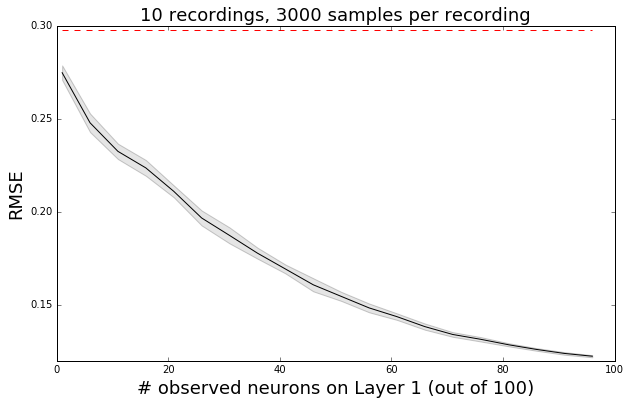

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

from matplotlib import pyplot as pl
import numpy as np
x = subnetSize;
y = np.mean(np.mean(rmses, axis=1), axis=0)
error = np.std(np.mean(rmses, axis=1), axis=0)
bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

pl.plot(x, y, 'k-')
horiz_line_data = np.array([bl for i in xrange(len(x))])
pl.plot(x, horiz_line_data, 'r--') 
pl.fill_between(x, y-error, y+error, alpha=0.2, facecolor='#808080')

pl.ylabel('RMSE',fontsize=18)
pl.xlabel('# observed neurons on Layer 1 (out of 100)', fontsize=18)
pl.title('%d recordings, %d samples per recording'%(nRecordings, nSamples), fontsize=18)

#pl.title(nRecordings ' recordings ')
pl.show()




In [ ]:
# save the rmse's
import pickle

with open('RMSE.dat','wb') as f:
    pickle.dump(rmses, f)
f.close()

In [ ]:
import pickle

with open('RMSE.dat', 'r') as f:
    rmses = pickle.load( f)
f.close()

In [11]:
import numpy as np
np.std(np.mean(rmses, axis=1), axis=0)
np.std(np.mean(rmses, axis=0), axis=0)

array([ 0.00551278,  0.01079165,  0.01165008,  0.01444574])